In [2]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

from pyscf import lib
from pyscf.pbc import scf, gto, df, cc

import sys 
sys.path.append('/home/daanverraes/CMM/libdmet_preview')

import libdmet.dmet.Hubbard as dmet
from libdmet.system import lattice
from libdmet.basis_transform import make_basis
from libdmet.utils import logger as log

log.verbose = "SECTION"
np.set_printoptions(4, linewidth=1000, suppress=False)

### ************************************************************
### System settings
### ************************************************************

bond_length_diffs = [-0.3 + i * 0.1 for i in range(7)]
Energy_RHF = []
Energy_DMET = []
Energy_KCCSD = []

for bond_length_diff in bond_length_diffs:
    cell = gto.Cell()
    cell.a = np.diag([10, 10, 2.583])
    cell.atom = [['C',[0, 0, 0.660+bond_length_diff]], ['C',[0, 0, 1.923]]]
    cell.unit = 'A'
    cell.basis = 'ccpvdz'
    cell.verbose = 4
    cell.precision = 1e-12
    cell.build(unit='Angstrom')

    kmesh = [1, 1, 5]
    Lat = lattice.Lattice(cell, kmesh)
    kpts = Lat.kpts
    nao = Lat.nao
    nkpts = Lat.nkpts

    exxdiv = None

    ### ************************************************************
    ### DMET settings 
    ### ************************************************************

    # system
    Filling = cell.nelectron / float(Lat.nscsites*2.0)
    restricted = True
    bogoliubov = False
    int_bath = True
    nscsites = Lat.nscsites
    Mu = 0.0
    last_dmu = 0.0
    beta = np.inf

    # DMET SCF control
    MaxIter = 100
    u_tol = 1.0e-6
    E_tol = 1.0e-6
    iter_tol = 4

    # DIIS
    adiis = lib.diis.DIIS()
    adiis.space = 4
    diis_start = 4
    dc = dmet.FDiisContext(adiis.space)
    trace_start = 3

    # solver and mu fit
    FCI = dmet.impurity_solver.FCI(restricted=restricted, tol=1e-8)
    CCSD = dmet.impurity_solver.CCSD(restricted=restricted, tol=5e-7, tol_normt=5e-5)
    solver = CCSD
    nelec_tol = 5.0e-6
    delta = 0.01
    step = 0.1
    load_frecord = False

    # vcor fit
    imp_fit = False
    emb_fit_iter = 500 # embedding fitting
    full_fit_iter = 0

    # vcor initialization
    vcor = dmet.vcor_zeros(restricted, bogoliubov, nscsites)

    ### ************************************************************
    ### SCF Mean-field calculation
    ### ************************************************************

    log.section("\nSolving SCF mean-field problem\n")
    gdf_fname = 'gdf_ints.h5'
    gdf = df.GDF(cell, kpts)
    gdf._cderi_to_save = gdf_fname
    gdf.build()

    chkfname = 'polyyne.chk'
    kmf = scf.KRHF(cell, kpts, exxdiv=exxdiv)
    kmf.with_df = gdf
    kmf.with_df._cderi = 'gdf_ints.h5'
    kmf.conv_tol = 1e-12
    kmf.max_cycle = 300
    kmf.chkfile = chkfname
    kmf.kernel()

    ### ************************************************************
    ### Pre-processing, LO and subspace partition
    ### ************************************************************

    log.section("\nPre-process, orbital localization and subspace partition\n")
    kmf = Lat.symmetrize_kmf(kmf)
    C_ao_iao, C_ao_iao_val, C_ao_iao_virt = make_basis.get_C_ao_lo_iao(Lat, kmf, minao='minao', full_return=True)
    #C_ao_iao, C_ao_iao_val, C_ao_iao_virt = make_basis.get_C_ao_lo_wannier(Lat, kmf, full_return=True)
    C_ao_iao = Lat.symmetrize_lo(C_ao_iao)

    ncore = 0
    nval = C_ao_iao_val.shape[-1]
    nvirt = cell.nao_nr() - ncore - nval
    Lat.set_val_virt_core(nval, nvirt, ncore)

    C_ao_lo = C_ao_iao
    Lat.set_Ham(kmf, gdf, C_ao_lo)

    ### ************************************************************
    ### DMET procedure
    ### ************************************************************

    # DMET main loop
    E_old = 0.0
    conv = False
    history = dmet.IterHistory()
    dVcor_per_ele = None
    if load_frecord:
        dmet.SolveImpHam_with_fitting.load("./frecord")

    for iter in range(MaxIter):
        log.section("\nDMET Iteration %d\n", iter)
        
        log.section("\nsolving mean-field problem\n")
        log.result("Vcor =\n%s", vcor.get())
        log.result("Mu (guess) = %20.12f", Mu)
        rho, Mu, res = dmet.RHartreeFock(Lat, vcor, Filling, Mu, beta=beta, ires=True, symm=True)
        #Lat.update_Ham(rho*2.0, rdm1_lo_k=res["rho_k"]*2.0)
        
        log.section("\nconstructing impurity problem\n")
        ImpHam, H1e, basis = dmet.ConstructImpHam(Lat, rho, vcor, int_bath=int_bath)
        ImpHam = dmet.apply_dmu(Lat, ImpHam, basis, last_dmu)
        basis_k = Lat.R2k_basis(basis)

        log.section("\nsolving impurity problem\n")
        solver_args = {"nelec": min((Lat.ncore+Lat.nval)*2, \
                cell.nelectron*nkpts), \
                "dm0": dmet.foldRho_k(res["rho_k"], basis_k)*2.0}

        
        rhoEmb, EnergyEmb, ImpHam, dmu = \
            dmet.SolveImpHam_with_fitting(Lat, Filling, ImpHam, basis, solver, \
            solver_args=solver_args, thrnelec=nelec_tol, \
            delta=delta, step=step)
        
        dmet.SolveImpHam_with_fitting.save("./frecord")
        last_dmu += dmu
        rhoImp, EnergyImp, nelecImp = \
                dmet.transformResults(rhoEmb, EnergyEmb, basis, ImpHam, H1e, \
                lattice=Lat, last_dmu=last_dmu, int_bath=int_bath, \
                solver=solver, solver_args=solver_args, rebuild_veff=True)
        EnergyImp *= nscsites
        log.result("last_dmu = %20.12f", last_dmu)
        log.result("E(DMET) = %20.12f", EnergyImp)
        solver.twopdm = None

        dump_res_iter = np.array([Mu, last_dmu, vcor.param, rhoEmb, basis, rhoImp, \
                C_ao_lo, rho, Lat.getFock(kspace=False)], dtype=object)
        np.save('./dmet_iter_%s.npy'%(iter), dump_res_iter, allow_pickle=True)

        log.section("\nfitting correlation potential\n")
        vcor_new, err = dmet.FitVcor(rhoEmb, Lat, basis, \
                vcor, beta, Filling, MaxIter1=emb_fit_iter,
                MaxIter2=full_fit_iter, method='CG', \
                imp_fit=imp_fit, ytol=1e-7, gtol=1e-4)

        if iter >= trace_start:
            # to avoid spiral increase of vcor and mu
            log.result("Keep trace of vcor unchanged")
            vcor_new = dmet.make_vcor_trace_unchanged(vcor_new, vcor)

        dVcor_per_ele = la.norm(vcor_new.param - vcor.param) / (len(vcor.param))
        dE = EnergyImp - E_old
        E_old = EnergyImp 
        
        if iter >= diis_start:
            pvcor = adiis.update(vcor_new.param)
            dc.nDim = adiis.get_num_vec()
        else:
            pvcor = vcor_new.param
        
        dVcor_per_ele = la.norm(pvcor - vcor.param) / (len(vcor.param))
        vcor.update(pvcor)
        log.result("trace of vcor: %s", \
                np.sum(np.diagonal((vcor.get())[:2], 0, 1, 2), axis=1))
        
        history.update(EnergyImp, err, nelecImp, dVcor_per_ele, dc)
        history.write_table()

        if dVcor_per_ele < u_tol and abs(dE) < E_tol and iter > iter_tol :
            conv = True
            break

    ## ************************************************************
    ## compare with KCCSD
    ## ************************************************************
    print("KCCSD Calculation: ...")
    mycc = cc.KCCSD(kmf)
    mycc.kernel()
    print ("KRCCSD energy (per unit cell)")
    print (mycc.e_tot - cell.energy_nuc())

    Energy_RHF.append(kmf.e_tot)
    Energy_DMET.append(EnergyImp + cell.energy_nuc())
    Energy_KCCSD.append(mycc.e_tot)

System: uname_result(system='Linux', node='MSI', release='5.15.133.1-microsoft-standard-WSL2', version='#1 SMP Thu Oct 5 21:02:42 UTC 2023', machine='x86_64')  Threads 12
Python 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
numpy 1.26.2  scipy 1.11.4
Date: Mon Dec 11 16:33:02 2023
PySCF version 2.4.0
PySCF path  /home/daanverraes/.local/lib/python3.10/site-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 2
[INPUT] num. electrons = 12
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = Angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 C      0.000000000000   0.000000000000   0.360000000000 AA    0.000000000000   0.000000000000   0.680301404843 Bohr   0.0
[INPUT]  2 C      0.000000000000   0.000000000000   1.923000000000 AA    0.000000000000   0.000000000000   3.633943337539 Bohr   

/tmp/ipykernel_699955/4007165531.py:39: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  Lat = lattice.Lattice(cell, kmesh)


Dec 11 16:33:12 ####### 
                ####### Pre-process, orbital localization and subspace partition
                ####### 


<class 'pyscf.pbc.gto.cell.Cell'> does not have attributes  nsites


Dec 11 16:33:14 ####### 
                ####### DMET Iteration 0
                ####### 
Dec 11 16:33:14 ####### 
                ####### solving mean-field problem
                ####### 
Dec 11 16:33:14 ####### 
                ####### constructing impurity problem
                ####### 
Dec 11 16:33:14 ####### 
                ####### solving impurity problem
                ####### 


Overwritten attributes  energy_nuc get_hcore get_ovlp  of <class 'pyscf.soscf.newton_ah.SecondOrderRHF'>
Overwritten attributes  energy_nuc get_hcore get_ovlp  of <class 'pyscf.scf.hf.RHF'>


Dec 11 16:33:29 ####### 
                ####### fitting correlation potential
                ####### 
Dec 11 16:33:31 ####### 
                ####### DMET Progress
                ####### 
Dec 11 16:33:31 ####### 
                ####### DMET Iteration 1
                ####### 
Dec 11 16:33:31 ####### 
                ####### solving mean-field problem
                ####### 
Dec 11 16:33:31 ####### 
                ####### constructing impurity problem
                ####### 
Dec 11 16:33:31 ####### 
                ####### solving impurity problem
                ####### 
Dec 11 16:33:39 ####### 
                ####### fitting correlation potential
                ####### 
Dec 11 16:33:39 ####### 
                ####### DMET Progress
                ####### 
Dec 11 16:33:39 ####### 
                ####### DMET Iteration 2
                ####### 
Dec 11 16:33:39 ####### 
                ####### solving mean-field problem
                ####### 
Dec 11 16:33:39 ####### 
    

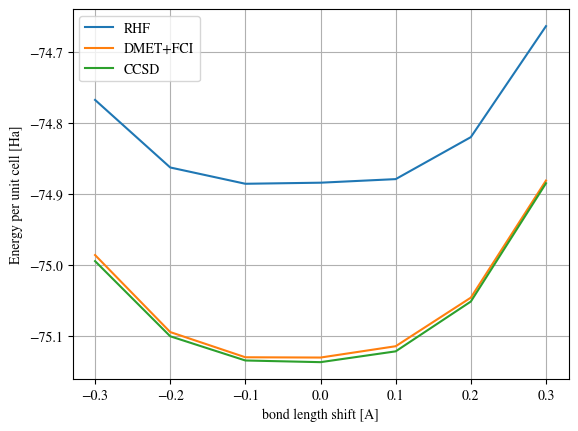

In [5]:
%matplotlib inline
plt.figure()
plt.plot(bond_lengths_diffs, Energy_RHF, label='RHF')
plt.plot(bond_lengths_diffs, Energy_DMET, label='DMET+CCSD')
plt.plot(bond_lengths_diffs, Energy_KCCSD, label='CCSD')
plt.grid()
plt.xlabel("bond length shift [A]")
plt.ylabel("Energy per unit cell [Ha]")
plt.legend()
plt.savefig("Polyyne_bond_length_energy")
plt.show()